# Kaggle: Zillow Housing Regression with LightGBM

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import gc

import matplotlib.pyplot as plt;
%matplotlib inline

from sklearn.model_selection import train_test_split;

In [16]:
print('Loading data ...')

names = ['parcelid', 'air_conditioning_type', 'architectural_style', 
         'area_basement', 'num_bathroom', 'num_bedroom', 'framing_type',
         'building_quality', 'num_bathroom_calc', 'deck_type',
         'area_firstfloor_finished', 'area_total_calc',
         'area_living_finished', 'perimeter_living',
         'area_total', 'area_firstfloor_unfinished',
         'area_base', 'fips', 'num_fireplace', 'num_fullbath',
         'num_garagecar', 'area_garage', 'hashottuborspa',
         'heating_type', 'latitude', 'longitude',
         'area_lot', 'num_pool', 'area_pools', 'pooltypeid10',
         'pooltypeid2', 'pooltypeid7', 'property_land_use_code',
         'property_land_use_type', 'property_zoning_desc',
         'census_raw_tract_block', 'region_city', 'region_county',
         'region_neighborhood', 'region_zipcode', 'num_room', 'story_type',
         'num_34_bath', 'material_type', 'num_unit',
         'area_patio', 'area_shed', 'build_year',
         'num_stories', 'flag_fireplace', 'tax_assessed_structure_value',
         'tax_assessed_parcel_value', 'tax_assessment_year', 'tax_assessed_land_alue',
         'tax_property', 'tax_delinquency_flag', 'tax_delinquency_year',
         'census_tract_block']

train  = pd.read_csv('train_2016_v2.csv')
prop   = pd.read_csv('properties_2016.csv', names=names, header=0)
sample = pd.read_csv('sample_submission.csv')

print('Binding to float32')

for c, dtype in zip(prop.columns, prop.dtypes):
    if dtype == np.float64:
        prop[c] = prop[c].astype(np.float32)
        
print(np.shape(train))
print(np.shape(prop))
print(np.shape(sample))

train.head()

Loading data ...


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Binding to float32
(90275, 3)
(2985217, 58)
(2985217, 7)


,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [17]:
print('Creating training set ...')

df_train = train.merge(prop, how='left', on='parcelid')
y_train  = df_train['logerror'].values
df_train = df_train.drop(['logerror', 'transactiondate'], axis=1)

print(np.shape(df_train))

print('Creating testing set ...')

sample['parcelid'] = sample['ParcelId'];
sample = sample.drop(['ParcelId', '201610', '201611', '201612', '201710', '201711', '201712'], axis=1)
df_sample = pd.merge(sample, prop, on='parcelid', how='left')

print(np.shape(df_sample))

Creating training set ...
(90275, 58)
Creating testing set ...
(2985217, 58)


In [18]:
print('Merging training and testing for preprocessing...')

assert(np.array_equal(df_train.columns.values, df_sample.columns.values))

rows_train = np.shape(df_train)[0]
df_all = pd.concat([df_train, df_sample])

print(np.shape(df_all))

Merging training and testing for preprocessing...
(3075492, 58)


In [19]:
df_all = pd.concat([df_all, pd.get_dummies(df_all['air_conditioning_type'], prefix='air_conditioning_type', dummy_na=True)], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['architectural_style'],   prefix='architectural_style',   dummy_na=True)], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['framing_type'],          prefix='framing_type',          dummy_na=True)], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['deck_type'],             prefix='deck_type',             dummy_na=True)], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['fips'],                  prefix='fips',                  dummy_na=True)], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['hashottuborspa'],        prefix='hashottuborspa',        dummy_na=True)], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['heating_type'],          prefix='heating_type',          dummy_na=True)], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['pooltypeid10'],          prefix='pooltypeid10',          dummy_na=True)], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['pooltypeid2'],           prefix='pooltypeid2',           dummy_na=True)], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['pooltypeid7'],           prefix='pooltypeid7',           dummy_na=True)], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['region_county'],         prefix='region_county',         dummy_na=True)], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['story_type'],            prefix='story_type',            dummy_na=True)], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['flag_fireplace'],        prefix='flag_fireplace',        dummy_na=True)], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['tax_assessment_year'],   prefix='tax_assessment_year',   dummy_na=True)], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['tax_delinquency_flag'],  prefix='tax_delinquency_flag',  dummy_na=True)], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['tax_delinquency_year'],  prefix='tax_delinquency_year',  dummy_na=True)], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['material_type'],         prefix='material_type',         dummy_na=True)], axis=1);

df_all = df_all.drop('air_conditioning_type', axis=1);
df_all = df_all.drop('architectural_style',   axis=1);
df_all = df_all.drop('framing_type',          axis=1);
df_all = df_all.drop('deck_type',             axis=1);
df_all = df_all.drop('fips',                  axis=1);
df_all = df_all.drop('hashottuborspa',        axis=1);
df_all = df_all.drop('heating_type',          axis=1);
df_all = df_all.drop('pooltypeid10',          axis=1);
df_all = df_all.drop('pooltypeid2',           axis=1);
df_all = df_all.drop('pooltypeid7',           axis=1);
df_all = df_all.drop('region_county',         axis=1);
df_all = df_all.drop('story_type',            axis=1);
df_all = df_all.drop('flag_fireplace',        axis=1);
df_all = df_all.drop('tax_assessment_year',   axis=1);
df_all = df_all.drop('tax_delinquency_flag',  axis=1);
df_all = df_all.drop('tax_delinquency_year',  axis=1);
df_all = df_all.drop('material_type',         axis=1);

#df_all = df_all.drop(['census_raw_tract_block', 'census_tract_block', 'region_city', 'region_neighborhood', 'region_zipcode'], axis=1);

print(np.shape(df_all))

(3075492, 157)


In [20]:
zoning_counts        = df_all['property_zoning_desc'].value_counts().reset_index();
land_use_type_counts = df_all['property_land_use_type'].value_counts().reset_index();
land_use_code_counts = df_all['property_land_use_code'].value_counts().reset_index();

df_all['property_zoning_desc']   = df_all['property_zoning_desc'].replace(  to_replace=zoning_counts[zoning_counts['property_zoning_desc']                 < 1000]['index'].values, value='zone_other')
df_all['property_land_use_type'] = df_all['property_land_use_type'].replace(to_replace=land_use_type_counts[land_use_type_counts['property_land_use_type'] < 1000]['index'].values, value='landtype_other')
df_all['property_land_use_code'] = df_all['property_land_use_code'].replace(to_replace=land_use_code_counts[land_use_code_counts['property_land_use_code'] < 1000]['index'].values, value='landuse_other')

df_all = pd.concat([df_all, pd.get_dummies(df_all['property_zoning_desc'])],   axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['property_land_use_type'])], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['property_land_use_code'])], axis=1);

df_all = df_all.drop('property_zoning_desc',   axis=1);
df_all = df_all.drop('property_land_use_type', axis=1);
df_all = df_all.drop('property_land_use_code', axis=1);

print(np.shape(df_all))

(3075492, 523)


In [21]:
df_train  = df_all[:rows_train]
df_sample = df_all[rows_train:]

print(np.shape(df_train))
print(np.shape(df_sample))

(90275, 523)
(2985217, 523)


In [22]:
x_train = df_train.drop(['parcelid'], axis=1)
print(x_train.shape, y_train.shape)

train_columns = x_train.columns

for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

(90275, 522) (90275,)


In [23]:
x_train.head()

,area_basement,num_bathroom,num_bedroom,building_quality,num_bathroom_calc,area_firstfloor_finished,area_total_calc,area_living_finished,perimeter_living,area_total,...,1210,122,1222,135,34,38,71,73,96,landuse_other
0,NaN,2.0,3.0,4.0,2.0,NaN,1684.0,1684.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,NaN,3.5,4.0,NaN,3.5,NaN,2263.0,2263.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,NaN,3.0,2.0,4.0,3.0,NaN,2217.0,2217.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,NaN,2.0,2.0,4.0,2.0,NaN,839.0,839.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,NaN,2.5,4.0,NaN,2.5,NaN,2283.0,2283.0,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0


In [24]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

In [25]:
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(72220, 522) (72220,)
(18055, 522) (18055,)


In [26]:
print('Building LightGBM Datasets...')

d_train = lgb.Dataset(x_train, label=y_train)
d_valid = lgb.Dataset(x_valid, label=y_valid)

#del x_train, x_valid; gc.collect()

Building DMatrix...


In [28]:
params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.01 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l2'          # or 'mae'
params['sub_feature'] = 0.5      # feature_fraction 
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf

watchlist = [d_valid]
lgr = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=10, verbose_eval=10)

#del d_train, d_valid

Train until valid scores didn't improve in 10 rounds.
[10]	valid_0's l2: 0.0275819
[20]	valid_0's l2: 0.0275459
[30]	valid_0's l2: 0.0275189
[40]	valid_0's l2: 0.0274955
[50]	valid_0's l2: 0.027469
[60]	valid_0's l2: 0.0274475
[70]	valid_0's l2: 0.0274233
[80]	valid_0's l2: 0.0274046
[90]	valid_0's l2: 0.0273903
[100]	valid_0's l2: 0.0273813
[110]	valid_0's l2: 0.0273708
[120]	valid_0's l2: 0.0273607
[130]	valid_0's l2: 0.0273488
[140]	valid_0's l2: 0.0273391
[150]	valid_0's l2: 0.0273309
[160]	valid_0's l2: 0.0273209
[170]	valid_0's l2: 0.0273136
[180]	valid_0's l2: 0.0273055
[190]	valid_0's l2: 0.0272998
[200]	valid_0's l2: 0.0272955
[210]	valid_0's l2: 0.0272927
[220]	valid_0's l2: 0.0272864
[230]	valid_0's l2: 0.0272829
[240]	valid_0's l2: 0.0272796
[250]	valid_0's l2: 0.0272751
[260]	valid_0's l2: 0.0272699
[270]	valid_0's l2: 0.0272683
[280]	valid_0's l2: 0.027266
[290]	valid_0's l2: 0.0272627
[300]	valid_0's l2: 0.0272588
[310]	valid_0's l2: 0.0272559
[320]	valid_0's l2: 0.02725

In [ ]:
print('Cross-validating...')

d_crossval = xgb.DMatrix(x_train.values, label=y_train)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

cvl = xgb.cv(params, d_crossval, num_boost_round=500, nfold=5, early_stopping_rounds=10, verbose_eval=10)

#del d_train, d_valid

In [49]:
cvl.head()

,test-mae-mean,test-mae-std,train-mae-mean,train-mae-std
0,0.488088,0.000464,0.488082,0.000120
1,0.478681,0.000471,0.478669,0.000125
2,0.469474,0.000474,0.469454,0.000136
3,0.460445,0.000469,0.460420,0.000152
4,0.451604,0.000483,0.451571,0.000150


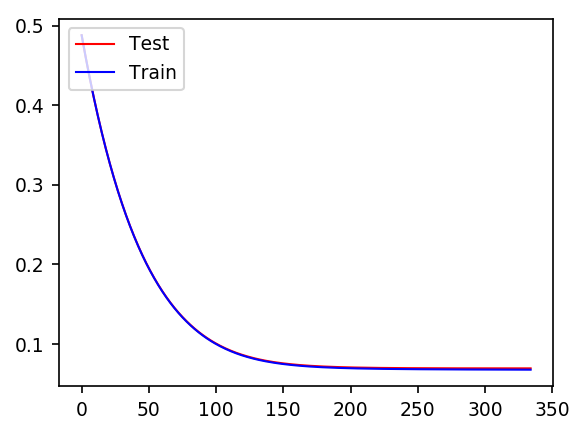

In [54]:
fig = plt.figure(figsize=(4, 3), dpi=150);

textsize   = 11;
legendsize = 9;
ticksize   = 9;
linethickness = 1;

axes1 = fig.add_subplot(111); 

axes1.plot(cvl.index.values, cvl['test-mae-mean'],  color='red',  linewidth = linethickness);
axes1.plot(cvl.index.values, cvl['train-mae-mean'], color='blue', linewidth = linethickness);

axes1.axis('tight');
axes1.tick_params(axis = 'both', which = 'major', labelsize = ticksize);
#axes1.set_title('$\mathrm{Single\ Crystal\ VO_{2}\ Reflectivity}$',size=20);
#axes1.set_xlabel('$\mathrm{Current\ [\mu A]}$', size=textsize);
#axes1.set_ylabel('$\mathrm{Voltage\ [V]}$',  size=textsize);

axes1.legend(["Test", "Train"], prop={'size': legendsize}, loc='upper left');

#t1 = axes1.text(0.02, 1.05, '(a)', color='black', fontsize=24, transform=axes1.transAxes);

fig.tight_layout();

In [29]:
print('Building test set ...')

df_test = df_sample.drop('parcelid', axis=1)

print(np.shape(df_test))

Building test set ...
(2985217, 522)


In [30]:
x_test = df_test[df_test.columns.values]

print(len(x_test.columns.values))
print(len(x_test.columns.unique()))

#del df_test, sample; gc.collect()

522
522


In [33]:
print('Predicting on test ...')

p_test = lgr.predict(x_test)

#del d_test; gc.collect()

sub = pd.read_csv('sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = p_test

Predicting on test ...


In [34]:
print('Writing csv ...')
sub.to_csv('17_06_16_LightGBM_MoreFeatures.csv', index=False, float_format='%.4f')

Writing csv ...
